# MPC latency, with driver for 4x40 QP Problem
Medición de latencia de comunicación

MPC con ADMM. Las matrices de entrada constantes son globales y no hace falta ingresarlas. Se elige un número de iteraciones de ADMM, luego, cada iteración del controlador se ingresa x0 y se obtiene u0.
Interfaz axilite.


### Driver especializado

In [26]:
from pynq import DefaultIP
import struct

class mpcDriver(DefaultIP):
    
    # IP Register Map
    CTRL_REG = 0x0000
    GIE_REG = 0x0004
    INTE_REG = 0x0008
    INTS_REG = 0x000C
    
    x0_REG = 0x0010
    r0_REG = 0x0020
    d0_REG = 0x0028
    IT_REG = 0x0040
    u0_REG = 0x0038
    
    N_SYS = 4
    M_SYS = 2
    D_SYS = 2
    N_QP = 4
    M_QP = 40
    
    def __init__(self, description):
        super().__init__(description=description)
        self.time_start = 0
        self.time_stop = 0

    bindto = ['xilinx.com:hls:mpc:1.0']

    def write_data(self, x0, r0, d0):
        self.write(0x0010, int.from_bytes(struct.pack("f", x0[0]),'little'))
        self.write(0x0014, int.from_bytes(struct.pack("f", x0[1]),'little'))
        self.write(0x0018, int.from_bytes(struct.pack("f", x0[2]),'little'))
        self.write(0x001c, int.from_bytes(struct.pack("f", x0[3]),'little'))
        self.write(0x0020, int.from_bytes(struct.pack("f", r0[0]),'little'))
        self.write(0x0024, int.from_bytes(struct.pack("f", r0[1]),'little'))
        self.write(0x0028, int.from_bytes(struct.pack("f", d0[0]),'little'))
        self.write(0x0030, int.from_bytes(struct.pack("f", d0[1]),'little'))
        self.write(0x0000, 0x0001) # start

    def write_IT(self, data):
        self.write(self.IT_REG, data)
        self.write(mpcDriver.GIE_REG, 0x0001) # General Interrupt Enable
        self.write(mpcDriver.INTE_REG, 0x0001) # DONE Interrupt Enable
    
    def read_u0(self):
        u0_0 = self.read(mpcDriver.u0_REG)
        u0_1 = self.read(mpcDriver.u0_REG+4)
        return (struct.unpack("f", u0_0.to_bytes(4,'little'))[0], struct.unpack("f", u0_1.to_bytes(4,'little'))[0])

    def get_extime(self):
        return self.time_stop-self.time_start

### Test

In [27]:
from pynq import Overlay
import time
overlay = Overlay('/home/xilinx/pynq/overlays/axi/axi_mpc3.bit')
mpc_ip = overlay.mpc_0
sniffer_ip = overlay.sniffer_0

In [6]:
x0 = [2.0, 0.0, 40.0, 0.0]
r0 = [0.0, 15.0]
d0 = [0.0, 0.0]

mpc_ip.write_IT(10)
mpc_ip.write_data(x0, r0, d0)
print(mpc_ip.read(0x0000))
print(mpc_ip.read(0x0000))
mpc_ip.read_u0()
mpc_ip.write(0x000c, 0x0003)

x0 = [-1.1628, 0.073162, 45.911, -2.8840]
mpc_ip.write_data(x0, r0, d0)
mpc_ip.read(0x0000)
mpc_ip.read_u0()
mpc_ip.write(0x000c, 0x0003)

x0 = [-3.0766, 0.38776, 15.114, -1.9301]
mpc_ip.write_data(x0, r0, d0)
mpc_ip.read(0x0000)
mpc_ip.read_u0()
mpc_ip.write(0x000c, 0x0003)

526
516
3212842432
1097078245
1079907191
1096670310
1083919578
1096205374


(4.853131294250488, 13.422910690307617)

In [43]:
x0 = [2.0, 0.0, 40.0, 0.0]
r0 = [0.0, 15.0]
d0 = [0.0, 0.0]
mpc_ip.write_IT(10)
for i in range(0,100):
    mpc_ip.write(0x0010,1)
    mpc_ip.write(0x0014,2)
    mpc_ip.write(0x0018,3)
    mpc_ip.write(0x001c,4)
    mpc_ip.write(0x0020,5)
    mpc_ip.write(0x0024,6)
    mpc_ip.write(0x0028,7)
    mpc_ip.write(0x0030,8)
    mpc_ip.write(0x0000,1)
    t = 0
    for j in range(0, 11):
        t += j
    mpc_ip.read(0x0038)
    mpc_ip.read(0x003c)
    mpc_ip.write(0x000c, 0x0003)
    for j in range(0, 20):
        t += j

## Read time intervals

In [29]:
import numpy as np
import matplotlib.pyplot as plt

### Write

In [30]:
# Write
N = 10
val = np.zeros(N*100)
for i in range(0,N):
    for j in range (0,101):
        mpc_ip.write(0x0038, j)
    for j in range(0,100):
        offset = j*4
        val[100*i+j] = sniffer_ip.read(0x0000+offset)
        #print("%d:\t%d" % (i,val[i]))
val.mean()

3322100.769

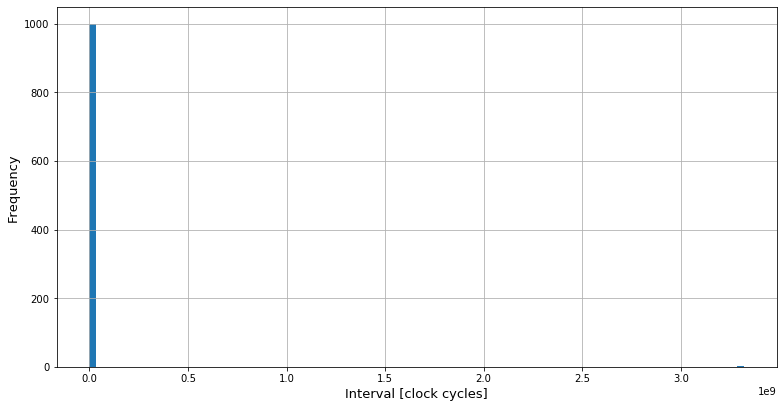

In [31]:
fig = plt.figure(figsize =(10, 5))
 
# Creating plot
ax = fig.add_axes([0, 0, 1, 1])
ax.hist(val, 100)
plt.grid(True)
plt.ylabel('Frequency', fontsize=13)
plt.xlabel('Interval [clock cycles]', fontsize=13)

# show plot
plt.show()

In [100]:
fig.savefig("axi_interval_write.pdf", bbox_inches='tight')

### Read

In [101]:
# Read

N = 10
val = np.zeros(N*100)
for i in range(0,N):
    for j in range (0,101):
        mpc_ip.read(0x0030)
    for j in range(0,100):
        offset = j*4
        val[100*i+j] = sniffer_ip.read(0x0000+offset)
        #print("%d:\t%d" % (i,val[i]))
val.mean()

881.63

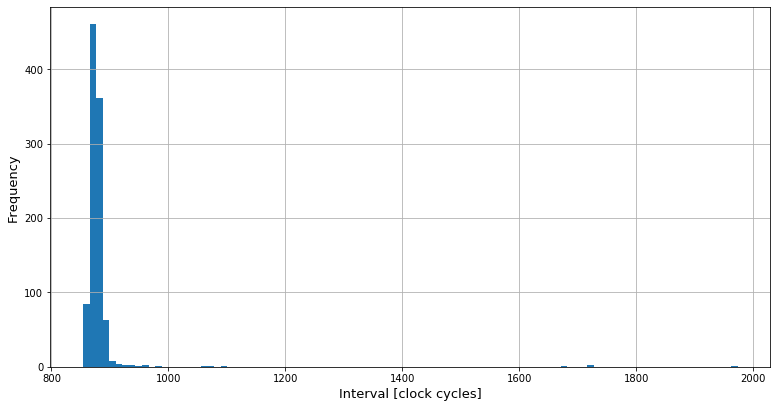

In [104]:
fig2 = plt.figure(figsize =(10, 5))
 
# Creating plot
ax2 = fig2.add_axes([0, 0, 1, 1])
ax2.hist(val, 100)
plt.grid(True)
plt.ylabel('Frequency', fontsize=13)
plt.xlabel('Interval [clock cycles]', fontsize=13)

# show plot
plt.show()

In [154]:
fig2.savefig("axi_interval_read.pdf", bbox_inches='tight')

### Write-Read

In [137]:
# write-read
N = 10
val = np.zeros(N*100)
for i in range(0,N):
    for j in range (0,50):
        mpc_ip.write(0x0038, j)
        mpc_ip.read(0x0030)
    mpc_ip.write(0x0038, j)
    for j in range(0,100):
        offset = j*4
        val[100*i+j] = sniffer_ip.read(0x0000+offset)
        #print("%d:\t%d" % (i,val[i]))
val.mean()

968.546

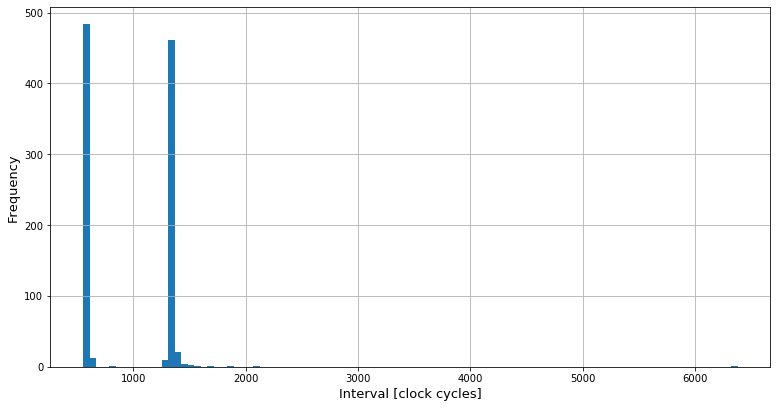

In [138]:
fig3 = plt.figure(figsize =(10, 5))
 
# Creating plot
ax3 = fig3.add_axes([0, 0, 1, 1])
#ax.set_xticklabels(horizon)
ax3.hist(val, 100)
plt.grid(True)
plt.ylabel('Frequency', fontsize=13)
plt.xlabel('Interval [clock cycles]', fontsize=13)
 
# show plot
plt.show()


In [139]:
fig3.savefig("axi_interval_write-read.pdf", bbox_inches='tight')

### MPC

In [156]:
# MPC
N = 10
val = np.zeros(100*N)
for i in range(0,N):
    mpc_ip.write_IT(10)
    for j in range (0,14):
        mpc_ip.write_x0(x0)
        mpc_ip.start()
        mpc_ip.read(0x0030)
        mpc_ip.read(0x0034)
    mpc_ip.read(0x0000)
    mpc_ip.read(0x0000)
    for j in range(0,100):
        offset = j*4
        val[100*i+j] = sniffer_ip.read(0x0000+offset)
        #print("%d:\t%d" % (i,val[i]))
val.mean()

1394.024

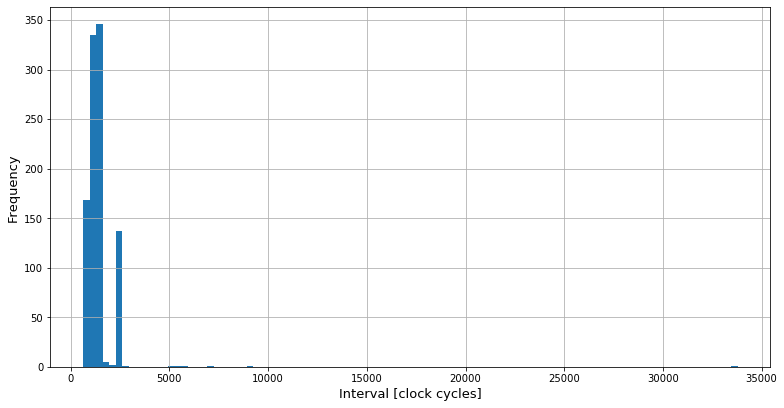

In [152]:
fig4 = plt.figure(figsize =(10, 5))
 
# Creating plot
ax4 = fig4.add_axes([0, 0, 1, 1])
#ax.set_xticklabels(horizon)
ax4.hist(val, 100)
plt.grid(True)
plt.ylabel('Frequency', fontsize=13)
plt.xlabel('Interval [clock cycles]', fontsize=13)
 
# show plot
plt.show()


In [172]:
fig4.savefig("axi_interval_mpc_messages.pdf", bbox_inches='tight')

In [158]:
# MPC
index = 0
sums = np.zeros(N*13)
for i in range(0,N):
    for j in range (0,13):
        for k in range (0,7):
            sums[i*13+j] = sums[i*13+j] + val[i*100+j*7+k+1]
sums.mean()

9842.430769230768

In [159]:
sums

array([11767.,  9445.,  9292.,  9202.,  9149.,  9084.,  9184.,  9185.,
        9157.,  9193.,  9176.,  9196.,  9249.,  9337., 28042.,  9300.,
        9222.,  9247.,  9165.,  9179.,  9190.,  9193., 11191.,  9273.,
        9151.,  9233.,  9327.,  9221.,  9205.,  9133.,  9227.,  9153.,
        9164.,  9142.,  9304.,  9191.,  9195.,  9159.,  9204.,  9343.,
       16178.,  9358.,  9180.,  9208.,  9093.,  9190.,  9098.,  9198.,
        9130.,  9083.,  9189.,  9140.,  9383.,  9216.,  9131.,  9195.,
        9155.,  9179.,  9120.,  9048.,  9089.,  9086.,  9129.,  9193.,
        9103.,  9380., 10029.,  9314.,  9149.,  9159.,  9181.,  9112.,
        9166.,  9191.,  9102.,  9079.,  9148.,  9203.,  9284.,  9204.,
       10439.,  9245.,  9139.,  9135.,  9194.,  9089.,  9144.,  9063.,
        9107.,  9066.,  9174.,  9230., 18484., 10441.,  9630.,  9583.,
        9285.,  9392.,  9260.,  9250.,  9271.,  9185.,  9325.,  9268.,
        9473.,  9359.,  9284.,  9301.,  9270.,  9300.,  9246.,  9350.,
      

In [157]:
val

array([ 5074.,  1525.,  1396.,  1314.,  1851.,  1478.,  1608.,  2595.,
        1401.,  1299.,  1278.,  1343.,   664.,  1010.,  2450.,  1351.,
        1275.,  1274.,  1292.,   655.,  1014.,  2431.,  1323.,  1266.,
        1247.,  1318.,   650.,   995.,  2403.,  1333.,  1255.,  1238.,
        1282.,   665.,   974.,  2402.,  1329.,  1238.,  1256.,  1286.,
         635.,   974.,  2366.,  1317.,  1278.,  1259.,  1279.,   654.,
         998.,  2399.,  1350.,  1281.,  1247.,  1295.,   648.,   974.,
        2390.,  1340.,  1281.,  1254.,  1263.,   650.,   986.,  2383.,
        1322.,  1279.,  1252.,  1308.,   651.,   988.,  2393.,  1343.,
        1269.,  1241.,  1279.,   654.,   999.,  2391.,  1332.,  1263.,
        1261.,  1283.,   658.,   989.,  2410.,  1357.,  1276.,  1239.,
        1291.,   665.,   999.,  2422.,  1365.,  1273.,  1278.,  1287.,
         649.,   972.,   904.,   851.,  2490.,  1359.,  1294.,  1271.,
        1290.,   674.,  1012.,  2437., 19618.,  1416.,  1319.,  1404.,
      

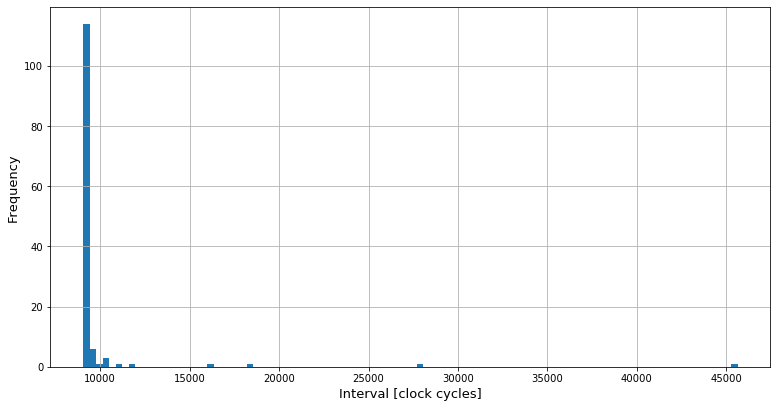

In [167]:
fig5 = plt.figure(figsize =(10, 5))
 
# Creating plot
ax5 = fig5.add_axes([0, 0, 1, 1])
#ax.set_xticklabels(horizon)
ax5.hist(sums, 100)
plt.grid(True)
plt.ylabel('Frequency', fontsize=13)
plt.xlabel('Interval [clock cycles]', fontsize=13)
 
# show plot
plt.show()


In [171]:
fig5.savefig("axi_interval_mpc_control.pdf", bbox_inches='tight')

In [155]:
for i in range(0,100):
    offset = i*4
    print("%d:\t%d" % (i, sniffer_ip.read(0x0000+offset)))

0:	2440
1:	1361
2:	1295
3:	1278
4:	1311
5:	651
6:	986
7:	2395
8:	1361
9:	1268
10:	1276
11:	1310
12:	628
13:	956
14:	2415
15:	1373
16:	1306
17:	1236
18:	1300
19:	657
20:	979
21:	2373
22:	1306
23:	1307
24:	1279
25:	1313
26:	653
27:	981
28:	2384
29:	1316
30:	1295
31:	1270
32:	1287
33:	654
34:	965
35:	2367
36:	1335
37:	1303
38:	1269
39:	1315
40:	651
41:	966
42:	2377
43:	1340
44:	1281
45:	8992
46:	1794
47:	738
48:	1017
49:	2573
50:	1395
51:	1280
52:	1262
53:	1326
54:	663
55:	978
56:	2431
57:	1386
58:	1304
59:	1263
60:	1306
61:	653
62:	977
63:	2409
64:	1366
65:	1301
66:	1269
67:	1261
68:	651
69:	966
70:	2377
71:	1346
72:	1294
73:	1266
74:	1293
75:	634
76:	959
77:	2397
78:	1336
79:	1280
80:	1267
81:	1309
82:	652
83:	971
84:	2386
85:	1356
86:	1305
87:	1258
88:	1297
89:	661
90:	952
91:	2372
92:	1361
93:	1279
94:	1286
95:	1277
96:	655
97:	959
98:	1860
99:	920
